# Population Inference with Redshifts

This notebook outlines how to derive population redshift distributions from a given collection of **redshift PDFs**. This simple case allows us to introduce most of the critical ideas and extensions that serve as the foundation for **hierarchical inference**, inference over samples, and inference over $p$-D **photometric PDFs**.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) = K(z_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) K(z_h | z) P(z) dz}
$$

where the notation $K(z_h|z)$ is meant to suggest a **kernel density** and differentiate it from $P(z_g|z)$.

## Noiseless Case

In the case where our observations are error-less such that $P(z_g|z) = \delta(z_g - z)$ (where $\delta(\cdot)$ is the Dirac delta function), our prior $P(z) = 1$ is uniform, and our basis is properly normalized such that $\int K(z_h|z) dz = 1$, this just reduces to

$$ P(z_g|z_h) = \frac{K(z_h|z_g)}{\sum_{g \in \mathbf{g}} K(z_h|z_g)} $$

which is just the value of our redshift basis $K(z_h|z)$ evaluated at $z_g$.

## Basis: Histogram

One common choice of basis is a series of redshift **bins** (i.e. a histogram), which can be modeled as a product of Heavyside functions

$$
K(z_h|z) = \frac{\mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z)}{z_h^{+} - z_h^{-}}, \quad z_h^{\pm} = (\bar{z}_h \pm \Delta z_h)/2
$$

where $z_h^{\pm}$ are the bin edges, $\bar{z}_h$ is the bin center, and $\Delta z_h$ is the bin width. In the errorless case above this just evaluates to $1/\Delta z_h$ if $z_h^{-} \leq z_g < z_h^{+}$ and $0$ otherwise.

We can define our projection over this basis using **Bayes Theorem** as

$$
P(h|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(h|g) = \sum_{g \in \mathbf{g}} \frac{P(g|h)P(h)}{P(g)} = \frac{1}{N_\mathbf{g}}\sum_{g \in \mathbf{g}} \frac{\mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g)}{z_h^{+} - z_h^{-}}
$$

where we have assumed our **prior** $P(h)=1$ over our redshift bins is uniform such that the **evidence** (also called the **marginal likelihood**) $P(g) = \sum_{g \in \mathbf{g}} P(g|h) P(h) = N_\mathbf{g}$ is just the total number of observed galaxies. Note that our number density 

$$ N(h|\mathbf{g}) = N_\mathbf{g} \times P(h|\mathbf{g}) = \sum_{g \in \mathbf{g}} \frac{\mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g)}{z_h^{+} - z_h^{-}} $$

This formalism might seem somewhat like an overly complicated way to say "count up the number of galaxies in each redshift bin and normalize then", but the generality will prove useful shortly once we start generalizing to other bases.

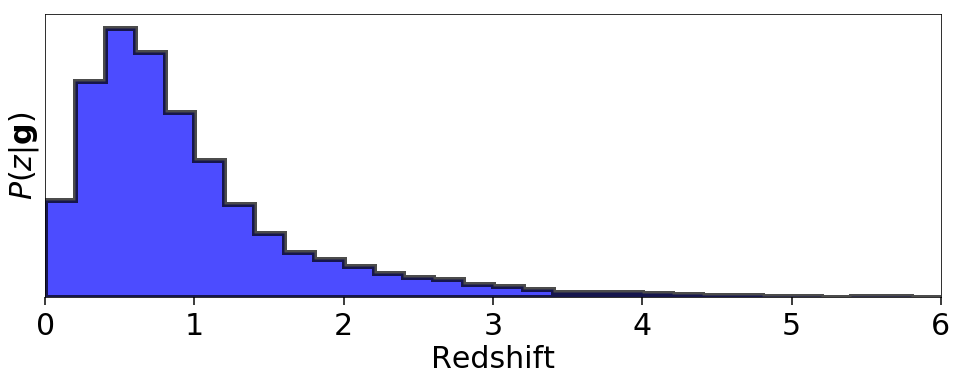

In [4]:
zbins = np.arange(0, 6.+1e-5, 0.2)  # redshift bins

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.tight_layout()

## Basis: Gaussian Kernel

Alternately, we can construct a smooth density estimate by using, e.g., a **Gaussian (Normal) kernel** as a basis rather than a bin centered at $z_h$ with a smoothing scale of $\sigma_h$ such that 

$$ K(z_h|z) = \mathcal{N}(\bar{z}_h|\mu=z, \sigma^2=\sigma^2_h) 
\equiv \frac{1}{\sqrt{2\pi}\sigma_h} \exp\left[ -\frac{1}{2} \frac{(z_h - z)^2}{\sigma_h^2} \right] $$

Our new estimator is then

$$
P(h|\mathbf{g}) = \frac{1}{N_\mathbf{g}} \sum_{g \in \mathbf{g}} \mathcal{N}(z_h|\mu=z_g, \sigma^2=\sigma^2_h) 
$$

This results in a smoother estimator.

Note that due to the nature of the problem, there is a symmetry between assign our kernel density estimates (i.e. "errors") to our redshift basis vs assigning them to our observed redshifts. This allows us to exploit some of the **kernel density estimation (KDE)** functionality of `frankenz` (which is designed to deal with projecting PDFs onto delta functions) to evaluate this.

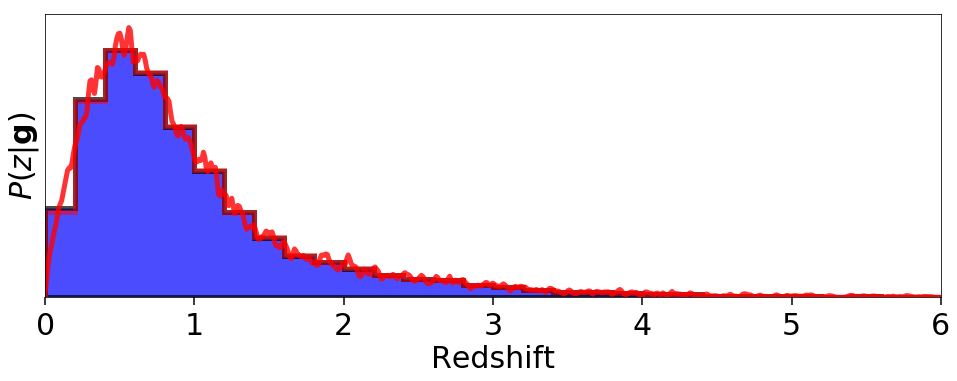

In [5]:
# KDE
zgrid = np.arange(-1., 7.+1e-5, 0.01)
Ngrid, sgrid = len(zgrid), 0.01
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * sgrid, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

## Noisy Case

In the case where $P(z_g|z) \neq \delta(z_g - z)$, we are again left with the more general case

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{\int P(z_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) K(z_h | z) P(z) dz}
$$

Let's define our PDFs to be Gaussian $\mathcal{N}(z|\mu=\hat{z}_g, \sigma=\hat{\sigma}_g)$ centered around noisy estimates $\hat{z}_g$ with error $\hat{\sigma}_g$. To avoid unphysical results, we truncate our PDFs at $z=0$.

In [6]:
# generate PDFs
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
cdf_draws = np.random.rand(Nobs)  # draw [0, 1]
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

To avoid edge effects, for our simulated data we will allow for negative redshifts so that producing a "correct" PDF involves simply shifting the mean of the Gaussian.

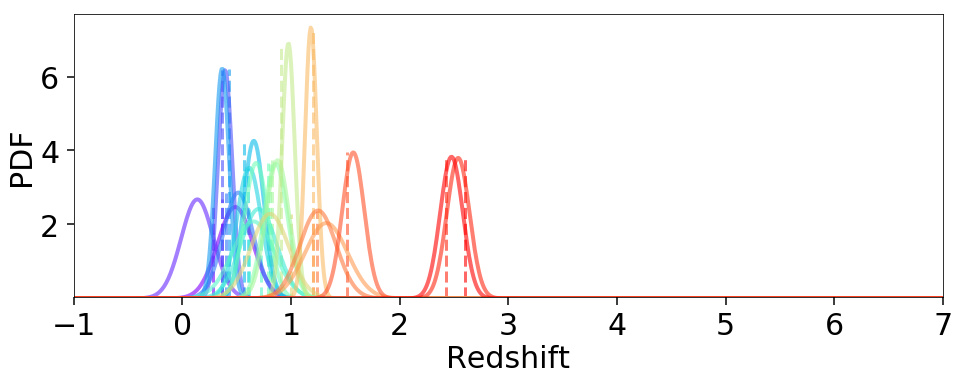

In [7]:
# plot some PDFs
plt.figure(figsize=(14, 6))
Nplot = 20
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(Nobs, size=Nplot)
idxs = idxs[np.argsort(redshifts[idxs])]
for i, c in zip(idxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=4, alpha=0.6)
    plt.vlines(redshifts[i], 0., max(zpdf[i]), color=c, 
               lw=3, linestyles='--', alpha=0.6)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()

Commonly, it is assumed that stacking these PDFs such that

$$
P(z|\mathbf{g}) \stackrel{?}{=} \frac{1}{N_g} \sum_{g \in \mathbf{g}} \mathcal{N}(z|\mu=\hat{z}_g, \sigma=\hat{\sigma}_g)
$$

will give access to the population distribution. In the context of the general case outlined above, this assumes that (1) our redshift prior $P(z)$ is uniform and (2) each basis $K(z_h|z) = \delta(z_h-z)$ is a delta function.

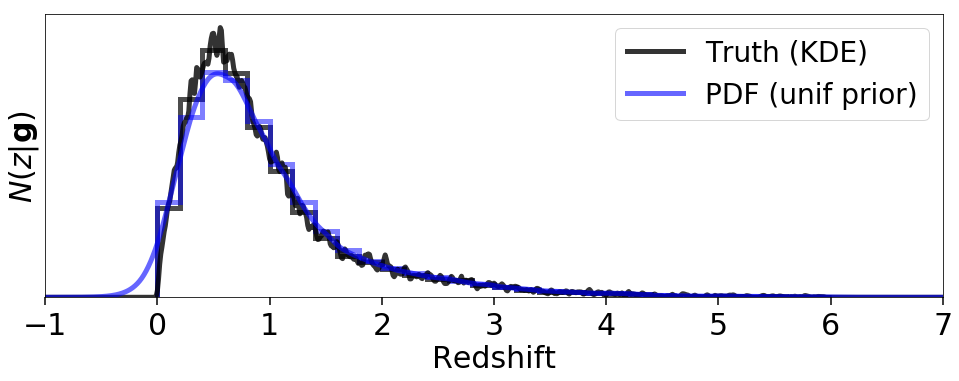

In [8]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, normed=True)
plt.hist(zgrid + 1e-5, bins=zbins, weights=zpdf.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see this is not actually a fully accurate reconstruction of the true PDF -- our noise broadens the estimated population redshift distribution, especially around the peak redshift density.

# Population Modeling

We now want to derive *errors* around our $N(h|\mathbf{g})$ predictions from our underlying PDFs. In particular, we want to generate a series of $k$ samples 

$$ \mathbf{n}_{\mathbf{g}}^{(1)}, \dots, \mathbf{n}_{\mathbf{g}}^{(k)} | \boldsymbol{\Lambda}_{\mathbf{g}} \sim P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) $$ 

where $\mathbf{n}_{\mathbf{g}} = \lbrace \dots, n_h(\mathbf{g}), \dots \rbrace = \lbrace \dots, N(h|\mathbf{g}), \dots \rbrace$ and $\boldsymbol{\Lambda}_{\mathbf{g}} = \sum_{g \in \mathbf{g}} \mathbf{p}_g$ are the (effective) observed counts.

In [9]:
# number of samples
Nsamples = 50

In general, we can write 

$$ P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) = \int P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\phi}) P(\boldsymbol{\phi}|\boldsymbol{\Lambda}_{\mathbf{g}}) d\boldsymbol{\phi} $$

where $\boldsymbol{\phi}$ are **nuisance parameters** that we want to marginalize over. $P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}})$ , however, frequently does not have a closed form. Here, we will instead approximate it using the **maximum-likelihood (ML)** result $P(\boldsymbol{\phi}|\boldsymbol{\Lambda}_{\mathbf{g}}) \approx \delta\left(\boldsymbol{\phi} - \boldsymbol{\phi}_{\textrm{ML}}(\boldsymbol{\Lambda}_\mathbf{g})\right)$ such that

$$ P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_{\mathbf{g}}) \approx P(\mathbf{n}_{\mathbf{g}}|\boldsymbol{\phi}_{\textrm{ML}}(\boldsymbol{\Lambda})) $$

## Poisson Approximation

A common approximation is that there are some number of galaxies $N_h$ within the $h$-th redshift bin, and we observe some random realization of this underlying count. The number of objects in each bin (assuming they're independent from each other) then follows a **Poisson distribution** where

$$ n_h|\lambda_h \sim \textrm{Pois}(\lambda = \lambda_h) $$

This treats $n_h(\mathbf{g})$ as a Poisson **random variable** (and $\mathbf{n}_{\mathbf{g}}$ as a Poisson **random vector**) that we want to simuate.

The ML solution for $\boldsymbol{\lambda}_{\mathbf{g}}(\hat{\mathbf{n}}_\mathbf{g})$ is

$$ \boldsymbol{\lambda}_{\mathbf{g},\textrm{ML}}(\hat{\mathbf{n}}_\mathbf{g}) = \boldsymbol{\Lambda}_{\mathbf{g}} $$

This gives us

$$ n_h|\Lambda_h \sim \textrm{Pois}(\lambda = \Lambda_h) $$

In [10]:
# draw Poisson samples
pdf1 = zpdf.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

The Poisson approximation implies that the number of objects we observe at a given redshift is simply a counting process with mean $\boldsymbol{\mu} = \boldsymbol{\lambda}_{\mathbf{g}} = \hat{\mathbf{n}}_{\mathbf{g}}$. This isn't quite right, since this assumes the number of objects observed at different $z_h$'s are independent, when we know that there must be *some* covariance due to each object's redshift PDF. More importantly, however, this approximation implies that the total number of objects we observe doesn't remain constant!

Let's see how our results look.

In [11]:
def zplot(samples, label='type', color='blue'):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.07)
     for i in range(Nsamples)]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

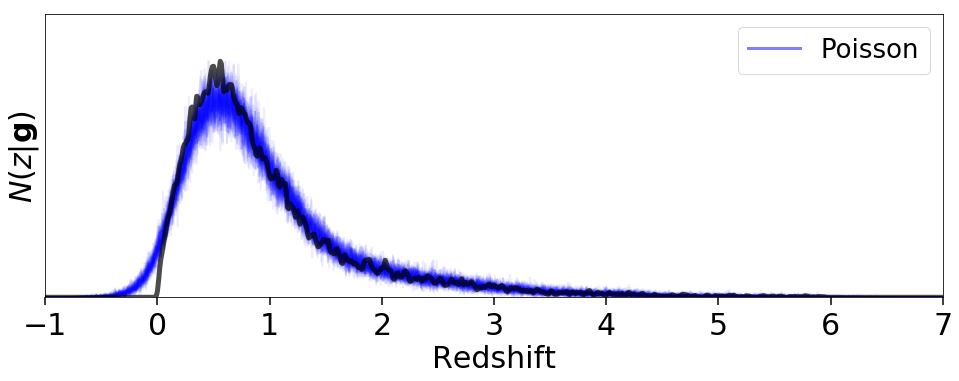

In [12]:
# plotting
plt.figure(figsize=(14, 6))
zplot(pdf1_samples, label='Poisson', color='blue')

## Multinomial Approximation

One improvement on the Poisson is to assume our observed counts $\mathbf{n}_\mathbf{g}$ for our observed set of $N_\mathbf{g}$ objects are drawn from the **Multinomial distribution** such that

$$ \mathbf{n}_{\mathbf{h}}|N_\mathbf{g},\mathbf{p}_\mathbf{g} \sim \textrm{Mult}\left(n = N_\mathbf{g}, \mathbf{p} = \mathbf{p}_{\mathbf{g}}\right) $$

The ML result is

$$ \mathbf{p}_{\mathbf{g},\textrm{ML}} = \boldsymbol{\Lambda}_\mathbf{g}/N_\mathbf{g} $$

Our number counts are then distributed as

$$
\mathbf{n}_{\mathbf{g}}|\boldsymbol{\Lambda}_\mathbf{g},N_\mathbf{g} \sim \textrm{Mult}\left(n = N_\mathbf{g}, \mathbf{p} = \boldsymbol{\Lambda}_\mathbf{g}/N_\mathbf{g}\right)
$$

In [13]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

The Multinomial approximation implies that the PDF of a random observed galaxy $g$ is proportional to the population PDF $P(z|\mathbf{g})$. In other words, a given galaxy is just a random draw from the population. The Multinomial has the benefit of keeping the overall number of galaxies $N_\mathbf{g}$ constant, and in doing so induces *negative* correlations among the individual categories (redshifts). However, this approximation ignores measurement errors (i.e. individual galaxy PDFs), which can induce additional correlations among redshifts.

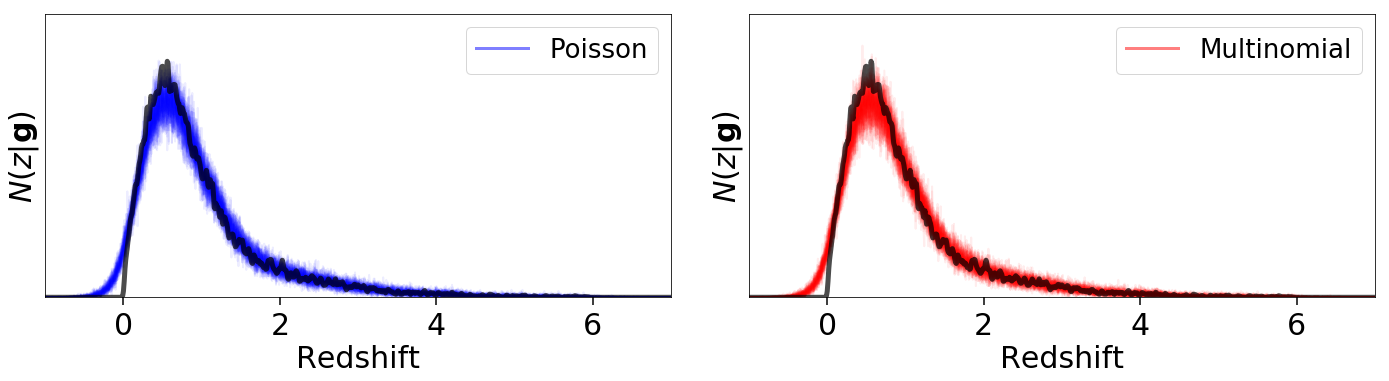

In [14]:
# plotting
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(1, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')

## Posterior Samples

Any particular galaxy $g$ with PDF $\mathbf{p}_g = \lbrace \dots, P(z_h|g), \dots \rbrace$ is actually located at a particular redshift $z_g$, with the corresponding redshift PDF modeling our uncertainty over its true redshift. Given $\mathbf{p}_g$, the distribution of $z_g$ ($\mathbf{n}_g$) is Categorial (Multinomial) such that

$$
z_g|\mathbf{p}_g \sim \textrm{Cat}\left(\mathbf{p}=\mathbf{p}_g\right)
\quad \Leftrightarrow \quad 
\mathbf{n}_g|\mathbf{p}_g \sim \textrm{Mult}\left(n=1, \mathbf{p}=\mathbf{p}_g\right)
$$

The redshift number density is then

$$
\mathbf{n}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\mathbf{p}_g
$$

This represents a convolution of a series of Multinomial-distributed random variables with different PDFs. Since $\boldsymbol{\Lambda}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{p}_g$, this implicitly includes the population distribution through each of the individual objects.

While this doesn't have a simple closed-form solution, it is straightforward to draw samples $\mathbf{n}_{\mathbf{g}}^{(i)}$ from this distribution by drawing redshifts from each galaxy's PDF and then stacking the results. This procedure intuitively makes sense: we simulate our uncertainties on $\mathbf{n}_\mathbf{g}$ by simulating our uncertainties on the individual redshifts from $\mathbf{p}_g$.

In [15]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf / zpdf.sum(axis=1)[:, None]
for j in range(Nsamples):
    sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

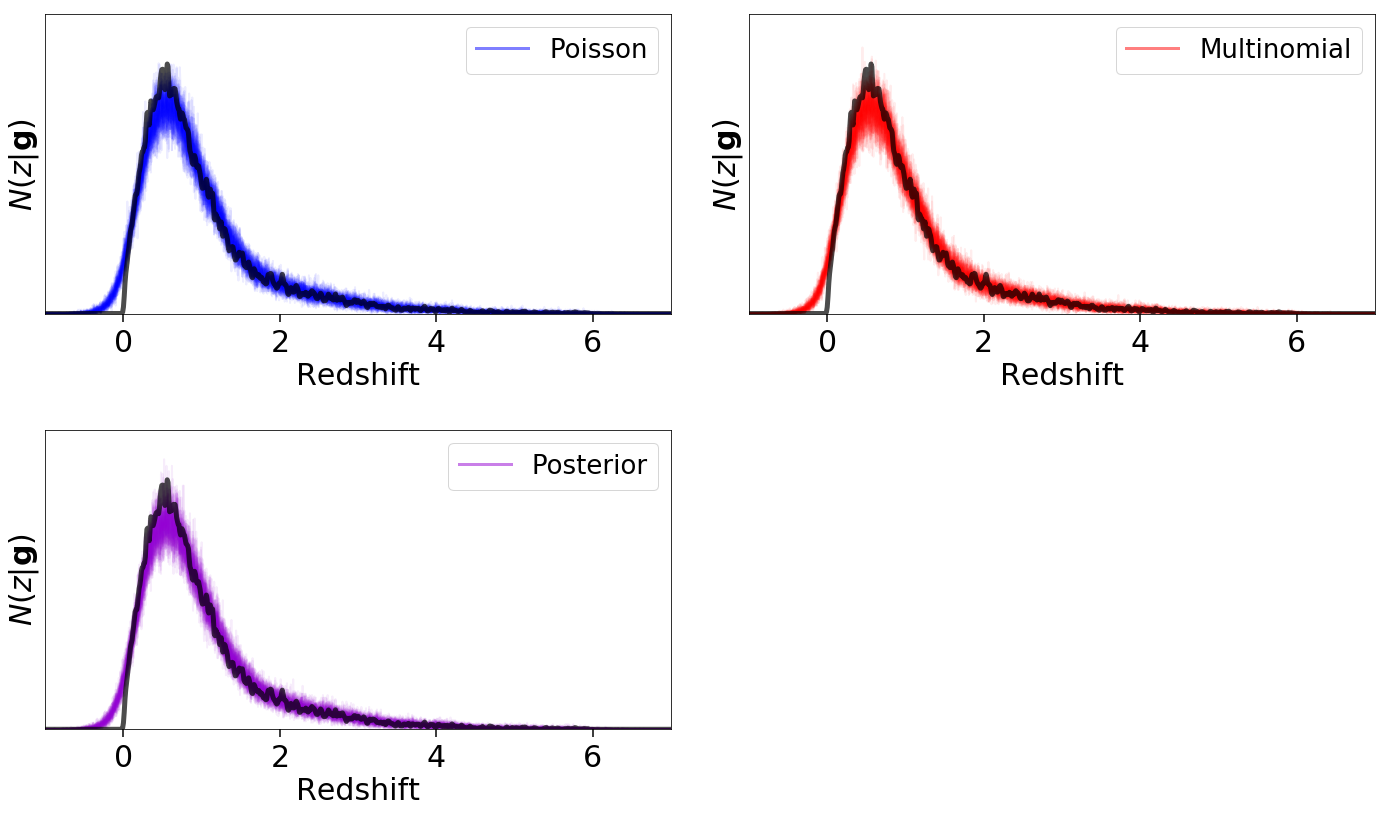

In [16]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')

Let's also check out how our results look at lower (binned) resolution.

In [17]:
def zplot_bin(samples, label='type', color='blue', binning=5):
    """Plot our binned draws."""
    [plt.hist(zgrid + 1e-5, zgrid[::binning], 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.15) 
     for i in range(Nsamples)]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zgrid[::binning], 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

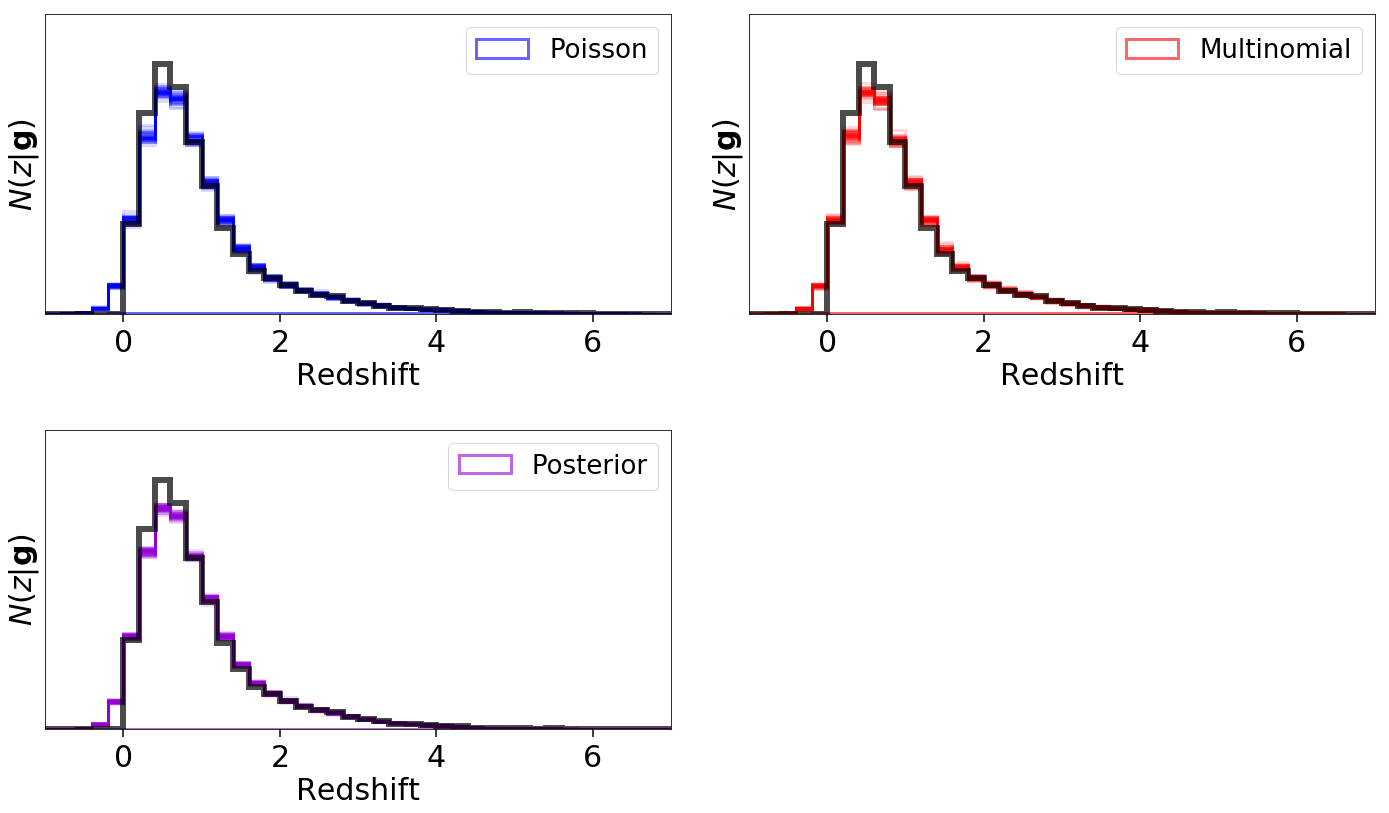

In [18]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)

Finally, let's check out the covariances among the draws for a few of our samples.

In [19]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zgrid)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=15, alpha=0.6)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], 
                                                           zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], 
                                                           zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

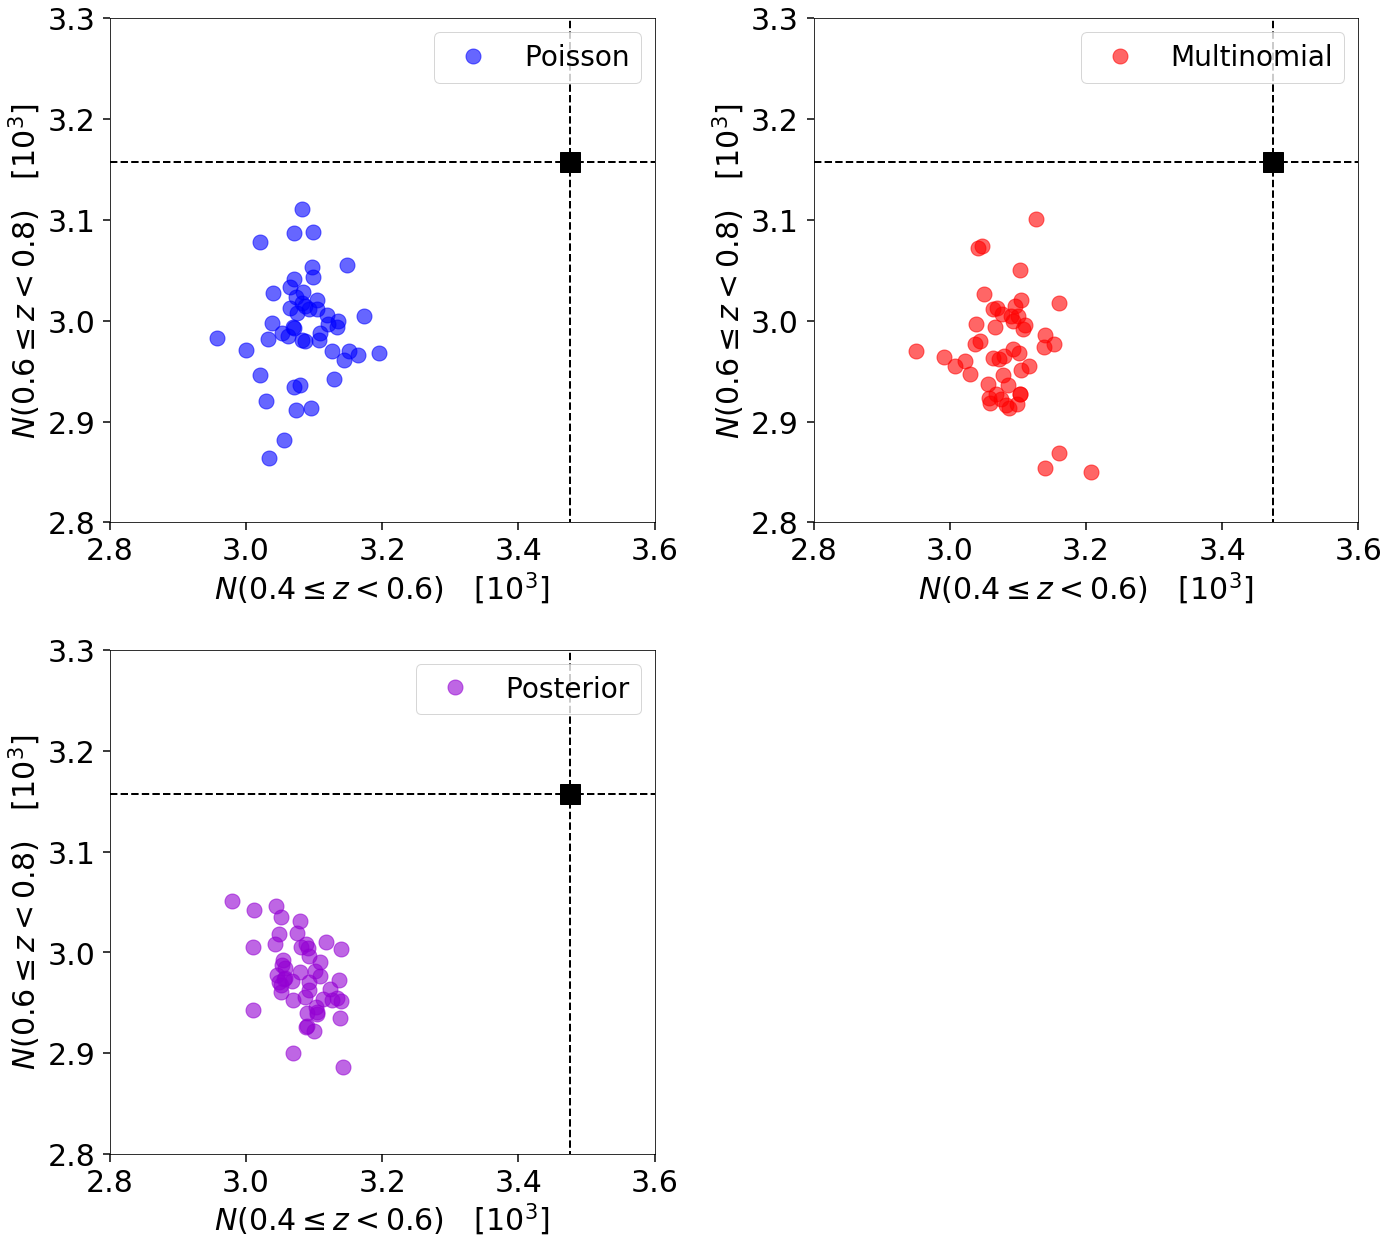

In [20]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='darkviolet', label='Posterior')

Even in this ideal case, our results appear to be slightly off from the true value. In addition, while the posterior results appear to capture the correct covariance structure, they also severely underestimate the uncertainties. To properly derive the distribution of the population, we need to model the population and individual objects jointly using hierarchical models.